# Customer Churn Analysis: EDA & Feature Engineering

This notebook performs comprehensive Exploratory Data Analysis (EDA) and feature engineering on the customer churn dataset.

In [13]:
print('start kernel')

start kernel


## 1. Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings

In [15]:

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Load and Inspect Data

In [16]:
# Load the dataset
from pathlib import Path
root = Path.cwd().parent
data_path = root / 'data' / 'raw' / 'train.csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst Few Rows:")
df.head(3)

Dataset Shape: (440833, 12)

First Few Rows:


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0


In [17]:
# Data Info
print("Data Info:")
print(df.info())
print("\n" + "="*50 + "\n")

# Basic Statistics
print("Descriptive Statistics:")
print(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB
None


Descriptive Statistics:
          CustomerID            Age         Tenure  Usage Frequency  \
count  440832.000000  440832.000000  

In [18]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values!")

# Check data types
print("\nData Types:")
print(df.dtypes)



Missing Values:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Data Types:
CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object


## 3. Target Variable Analysis

Churn Distribution:
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

Churn Rate:
Churn
1.0    56.71
0.0    43.29
Name: proportion, dtype: float64


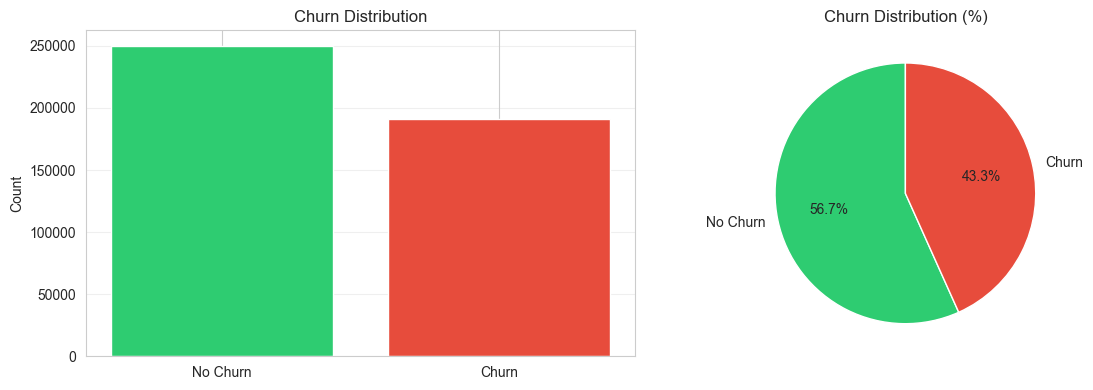

In [19]:
# Churn distribution
print("Churn Distribution:")
print(df['Churn'].value_counts())
print("\nChurn Rate:")
print((df['Churn'].value_counts(normalize=True) * 100).round(2))

# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
churn_counts = df['Churn'].value_counts()
axes[0].bar(['No Churn', 'Churn'], churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Count')
axes[0].set_title('Churn Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
churn_pct = df['Churn'].value_counts(normalize=True) * 100
axes[1].pie(churn_pct.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Churn Distribution (%)')

plt.tight_layout()
plt.show()

## 4. Numerical Features Analysis

In [20]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Churn')  # Remove target
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("\nCategorical Columns:", categorical_cols)

Numerical Columns: ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

Categorical Columns: ['Gender', 'Subscription Type', 'Contract Length']


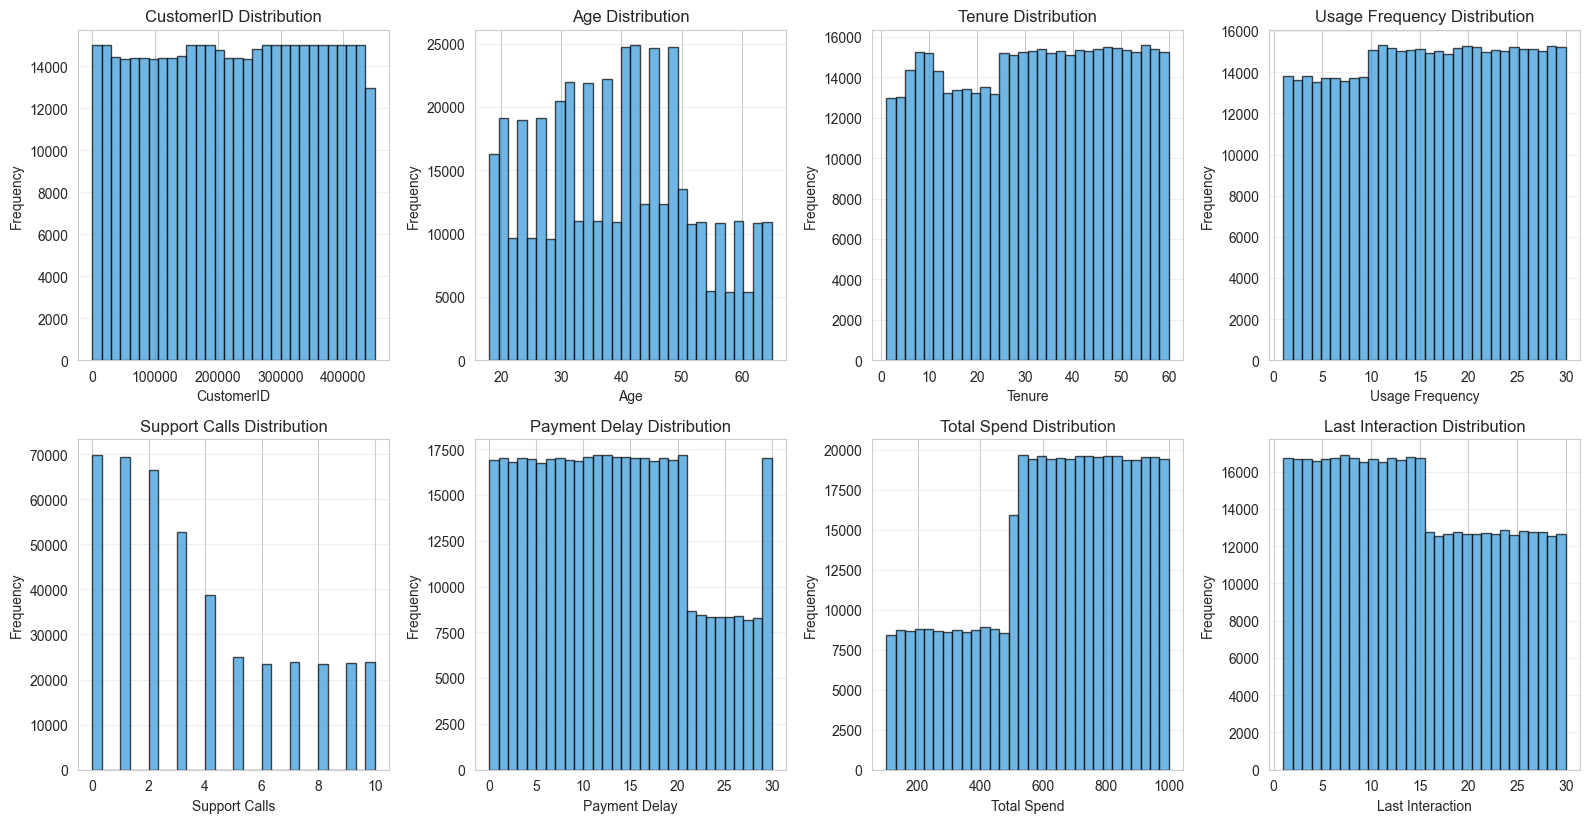

In [21]:
# Distributions of numerical features
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

# Remove empty subplots
for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [22]:
# Check for outliers using IQR method
print("Outlier Analysis (IQR Method):")
print("="*60)

outliers_summary = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = (outlier_count / len(df)) * 100
    
    outliers_summary[col] = {
        'outlier_count': outlier_count,
        'outlier_percentage': outlier_pct,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    if outlier_count > 0:
        print(f"\n{col}:")
        print(f"  Outliers: {outlier_count} ({outlier_pct:.2f}%)")
        print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

Outlier Analysis (IQR Method):


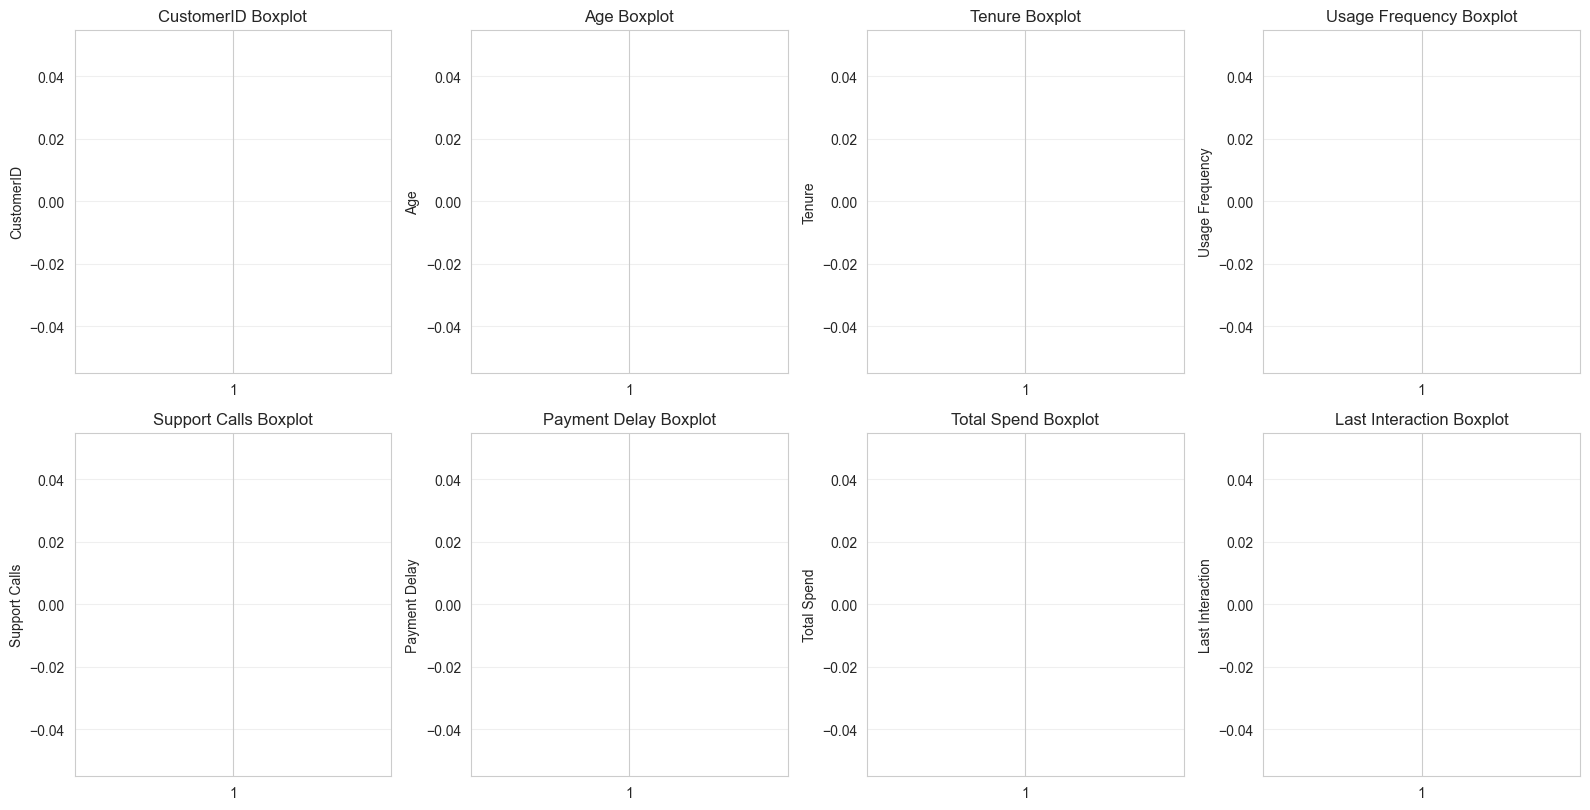

In [23]:
# Box plots for outlier visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].boxplot(df[col], vert=True)
    axes[idx].set_title(f'{col} Boxplot')
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 5. Categorical Features Analysis

In [24]:
# Distribution of categorical features
for col in categorical_cols:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts())
    print("-" * 40)


Gender Value Counts:
Gender
Male      250252
Female    190580
Name: count, dtype: int64
----------------------------------------

Subscription Type Value Counts:
Subscription Type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64
----------------------------------------

Contract Length Value Counts:
Contract Length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64
----------------------------------------


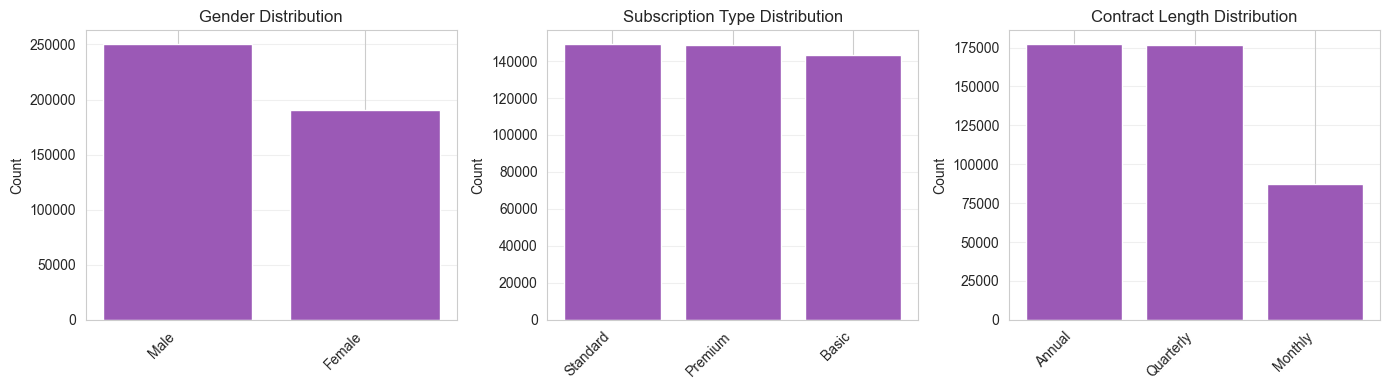

In [25]:
# Visualize categorical features
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(14, 4))

for idx, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    axes[idx].bar(range(len(value_counts)), value_counts.values, color='#9b59b6')
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

In [26]:
# Correlation matrix for numerical features
correlation_matrix = df[numerical_cols + ['Churn']].corr()

# Feature correlation with Churn
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)
print("Correlation with Churn:")
print(churn_correlation)
print("\n" + "="*50)

Correlation with Churn:
Churn               1.000000
Support Calls       0.574267
Payment Delay       0.312129
Age                 0.218394
Last Interaction    0.149616
Usage Frequency    -0.046101
Tenure             -0.051919
Total Spend        -0.429355
CustomerID         -0.839365
Name: Churn, dtype: float64



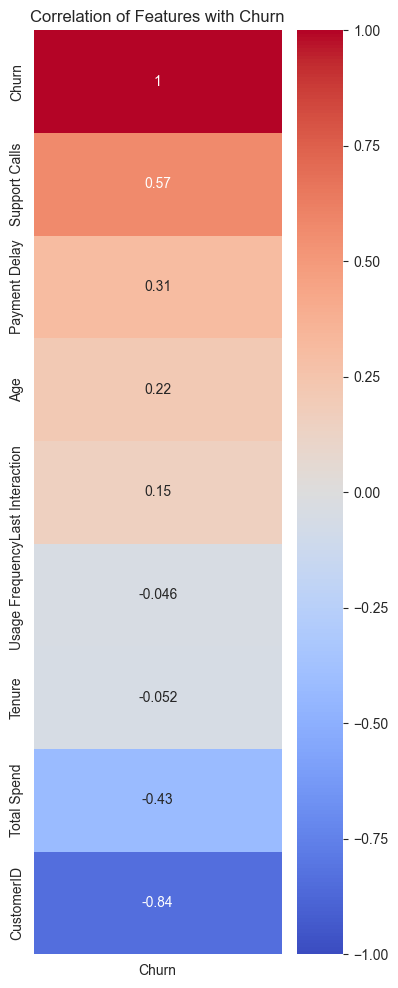

In [27]:
# Correlation heatmap
corr_matrix = df.corr(numeric_only=True)
churn_corr = corr_matrix[['Churn']].sort_values(ascending=False,by='Churn')

# Plot heatmap
plt.figure(figsize=(4, 12))
sns.heatmap(churn_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Churn')
plt.show()

## 7. Churn vs Features Analysis

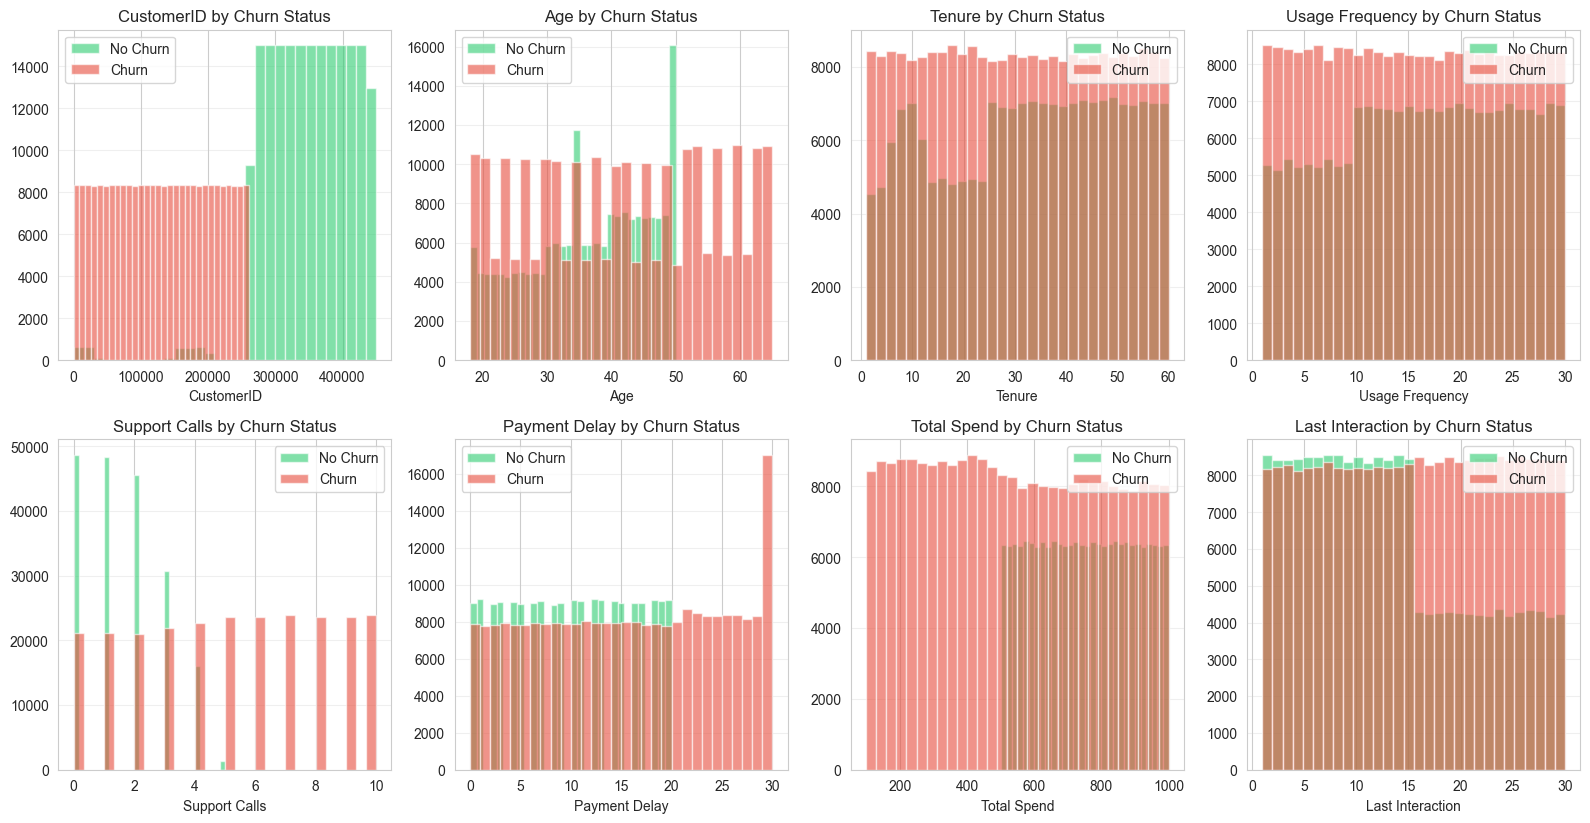

In [28]:
# Numerical features vs Churn
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    df[df['Churn'] == 0][col].hist(bins=30, alpha=0.6, label='No Churn', ax=axes[idx], color='#2ecc71')
    df[df['Churn'] == 1][col].hist(bins=30, alpha=0.6, label='Churn', ax=axes[idx], color='#e74c3c')
    axes[idx].set_title(f'{col} by Churn Status')
    axes[idx].set_xlabel(col)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

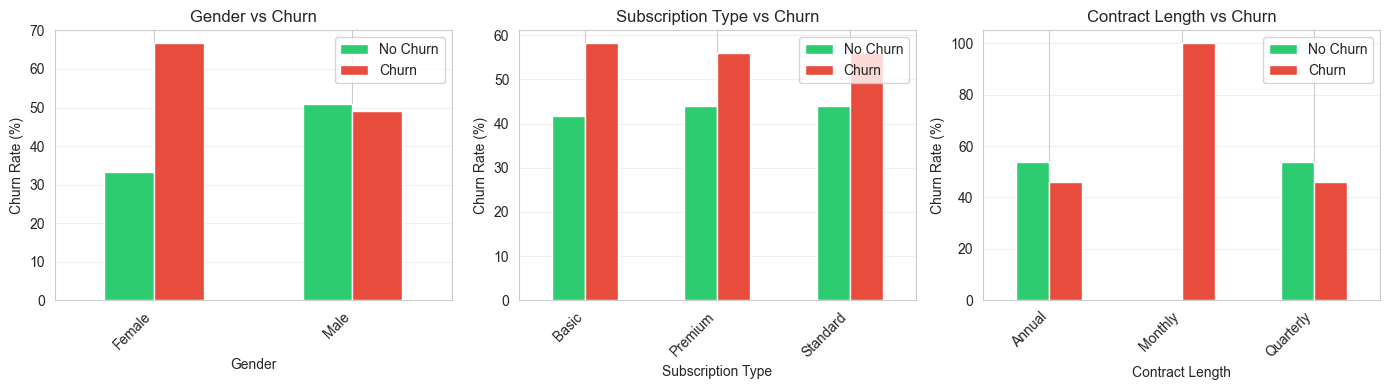

In [29]:
# Categorical features vs Churn
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(14, 4))

for idx, col in enumerate(categorical_cols):
    churn_by_cat = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_by_cat.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{col} vs Churn')
    axes[idx].set_ylabel('Churn Rate (%)')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].legend(['No Churn', 'Churn'])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Engineering

In [30]:
# Create a copy for feature engineering
df_engineered = df.copy()

print("Original Features Shape:", df_engineered.shape)
print("Original Features:", df_engineered.columns.tolist())

Original Features Shape: (440833, 12)
Original Features: ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']


In [31]:
# 1. Customer Lifetime Value (CLV) - based on spend and tenure
df_engineered['CLV'] = df_engineered['Total Spend'] * (df_engineered['Tenure'] / 12)

# 2. Support Efficiency - Support calls relative to tenure
# how much support calls need for per month. more calls mean less efficiency and likely to churn.
df_engineered['Support_Efficiency'] = df_engineered['Support Calls'] / (df_engineered['Tenure'] + 1)

# 3. Payment Reliability => inverse of payment delay
# the lower the payment delay, the higher the reliability.
df_engineered['Payment_Reliability'] = 1 / (df_engineered['Payment Delay'] + 1)

# 4. Usage Score - normalized usage frequency
# the more value means customer is using more services and less likely to churn. 
df_engineered['Usage_Score'] = df_engineered['Usage Frequency'] / df_engineered['Usage Frequency'].max() * 100

# 5. Engagement Index - combines usage and support interaction
# High usage + low support => healthy engagement
# Low usage + high support => frustrated, churn risk
# Low usage + low support => silent disengagement (high risky)
df_engineered['Engagement_Index'] = (df_engineered['Usage Frequency'] + df_engineered['Support Calls']) / 2

# 6. Spend per Interaction - total spend relative to last interaction
# High spend + recent interaction => engaged, valuable
# High spend + long gap => value আছে কিন্তু disengaged (high churn risk)
# Low spend + frequent interaction => low-value, high-cost customer
df_engineered['Spend_per_Interaction'] = df_engineered['Total Spend'] / (df_engineered['Last Interaction'] + 1)

# 7. Risk Score - composite metric indicating churn risk
# Payment delay ↑ => financial friction => risk ↑
# Usage ↓ => disengagement => risk ↑
# Tenure ↑ => loyalty => risk ↓
# Support calls ↑ => frustration => risk ↑
df_engineered['Risk_Score'] = (
    (df_engineered['Payment Delay'] / df_engineered['Payment Delay'].max()) * 0.3 +
    (1 - df_engineered['Usage Frequency'] / df_engineered['Usage Frequency'].max()) * 0.3 +
    (df_engineered['Tenure'] / df_engineered['Tenure'].max()) * (-0.2) +  # Negative because longer tenure = lower risk
    (df_engineered['Support Calls'] / df_engineered['Support Calls'].max()) * 0.2
)

# 8. Tenure Category - binned tenure
df_engineered['Tenure_Category'] = pd.cut(df_engineered['Tenure'], 
                                           bins=[0, 12, 24, 36, 48, 60],
                                           labels=['0-12M', '12-24M', '24-36M', '36-48M', '48M+'])

# 9. Age Group - binned age
df_engineered['Age_Group'] = pd.cut(df_engineered['Age'], 
                                     bins=[0, 30, 40, 50, 60, 100],
                                     labels=['18-30', '30-40', '40-50', '50-60', '60+'])

# 10. Spend Category - binned total spend
df_engineered['Spend_Category'] = pd.cut(df_engineered['Total Spend'], 
                                          bins=3, 
                                          labels=['Low', 'Medium', 'High'])

print("\nNew Features Created:")
print("1. CLV (Customer Lifetime Value)")
print("2. Support_Efficiency")
print("3. Payment_Reliability")
print("4. Usage_Score")
print("5. Engagement_Index")
print("6. Spend_per_Interaction")
print("7. Risk_Score")
print("8. Tenure_Category")
print("9. Age_Group")
print("10. Spend_Category")

print("\nNew Features Shape:", df_engineered.shape)
print("\nNew Features Preview:")
print(df_engineered[['CLV', 'Support_Efficiency', 'Payment_Reliability', 'Usage_Score', 'Engagement_Index']].head())


New Features Created:
1. CLV (Customer Lifetime Value)
2. Support_Efficiency
3. Payment_Reliability
4. Usage_Score
5. Engagement_Index
6. Spend_per_Interaction
7. Risk_Score
8. Tenure_Category
9. Age_Group
10. Spend_Category

New Features Shape: (440833, 22)

New Features Preview:
           CLV  Support_Efficiency  Payment_Reliability  Usage_Score  \
0  3029.000000            0.125000             0.052632    46.666667   
1  2274.416667            0.200000             0.111111     3.333333   
2   215.833333            0.400000             0.052632    13.333333   
3  1254.000000            0.179487             0.125000    70.000000   
4  1645.333333            0.151515             0.111111    66.666667   

   Engagement_Index  
0               9.5  
1               5.5  
2               5.0  
3              14.0  
4              12.5  


In [32]:
# Display statistics of engineered features
engineered_features = ['CLV', 'Support_Efficiency', 'Payment_Reliability', 'Usage_Score', 
                       'Engagement_Index', 'Spend_per_Interaction', 'Risk_Score']

print("Engineered Features Statistics:")
print(df_engineered[engineered_features].describe())

Engineered Features Statistics:
                 CLV  Support_Efficiency  Payment_Reliability    Usage_Score  \
count  440832.000000       440832.000000        440832.000000  440832.000000   
mean     1651.748482            0.217487             0.147462      52.691645   
std      1161.162138            0.427803             0.199774      28.620805   
min         8.333333            0.000000             0.032258       3.333333   
25%       646.000000            0.033333             0.050000      30.000000   
50%      1462.000000            0.094340             0.076923      53.333333   
75%      2480.673333            0.217391             0.142857      76.666667   
max      5000.000000            5.000000             1.000000     100.000000   

       Engagement_Index  Spend_per_Interaction     Risk_Score  
count     440832.000000          440832.000000  440832.000000  
mean           9.705965              69.654136       0.239483  
std            4.527395              77.362218       0.

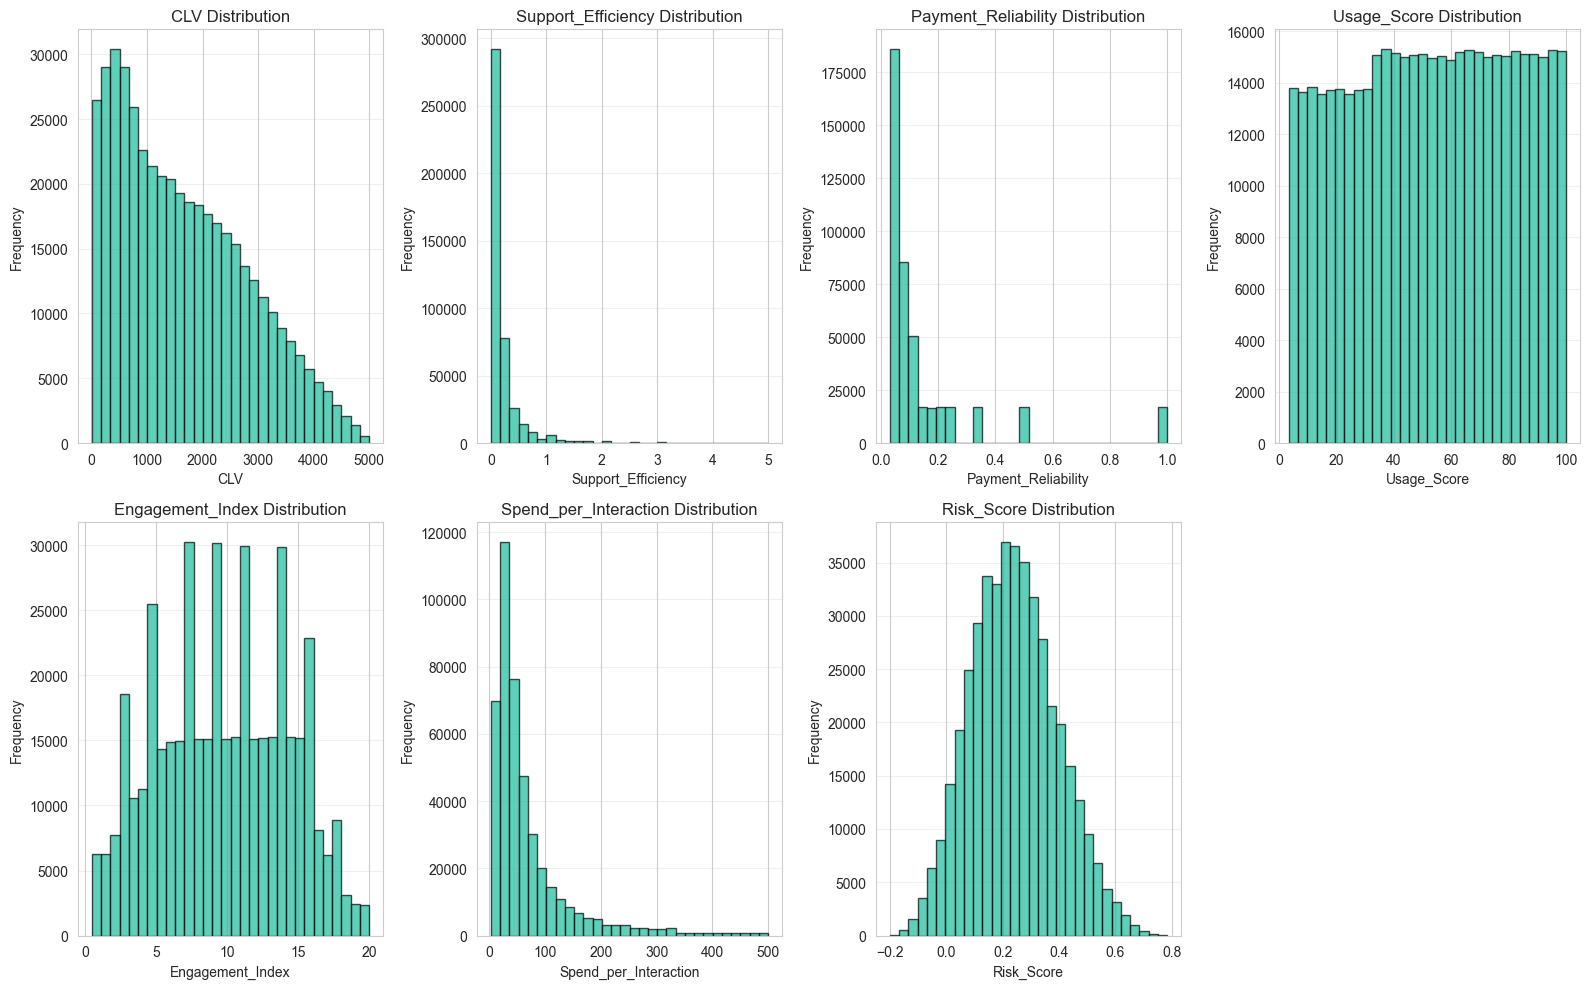

In [33]:
# Visualize engineered features
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(engineered_features):
    axes[idx].hist(df_engineered[col], bins=30, edgecolor='black', alpha=0.7, color='#1abc9c')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

Engineered Features Correlation with Churn:
Churn                    1.000000
Risk_Score               0.443961
Support_Efficiency       0.265607
Engagement_Index         0.151002
Usage_Score             -0.046101
Payment_Reliability     -0.112909
Spend_per_Interaction   -0.231777
CLV                     -0.274808
Name: Churn, dtype: float64


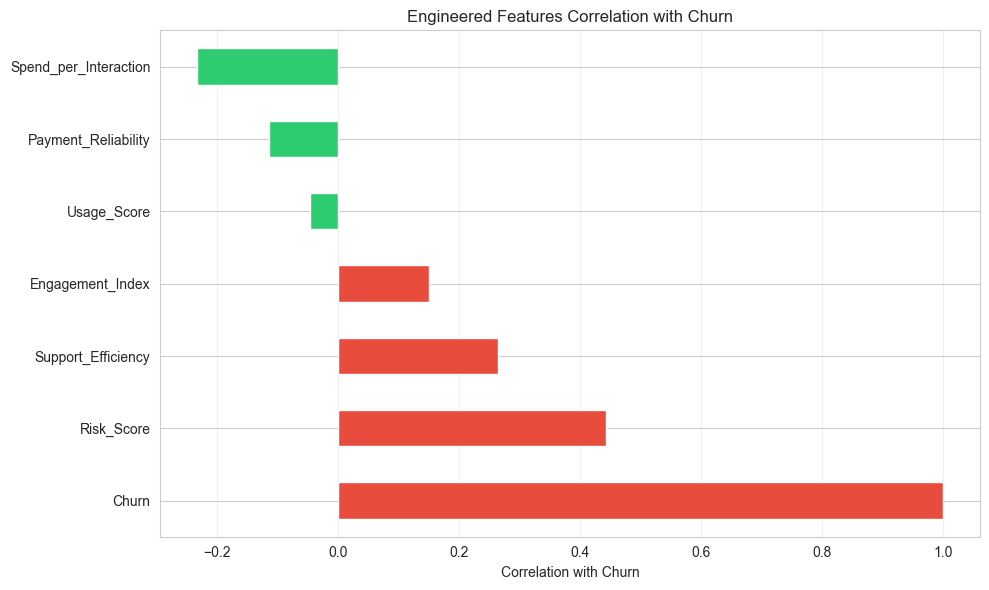

In [34]:
# Correlation of engineered features with churn
engineered_churn_corr = df_engineered[engineered_features + ['Churn']].corr()['Churn'].sort_values(ascending=False)
print("Engineered Features Correlation with Churn:")
print(engineered_churn_corr)

# Visualize
plt.figure(figsize=(10, 6))
engineered_churn_corr[:-1].plot(kind='barh', color=['#e74c3c' if x > 0 else '#2ecc71' for x in engineered_churn_corr[:-1]])
plt.xlabel('Correlation with Churn')
plt.title('Engineered Features Correlation with Churn')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Encoding Categorical Variables

In [35]:
# Create encoding dictionary
df_encoded = df_engineered.copy()

# Label encode Gender
le_gender = LabelEncoder()
df_encoded['Gender'] = le_gender.fit_transform(df_encoded['Gender'])

# One-hot encode Subscription Type
subscription_dummies = pd.get_dummies(df_encoded['Subscription Type'], prefix='Sub')
df_encoded = pd.concat([df_encoded, subscription_dummies], axis=1)

# One-hot encode Contract Length
contract_dummies = pd.get_dummies(df_encoded['Contract Length'], prefix='Contract')
df_encoded = pd.concat([df_encoded, contract_dummies], axis=1)

# One-hot encode Tenure Category
tenure_dummies = pd.get_dummies(df_encoded['Tenure_Category'], prefix='TenureGroup')
df_encoded = pd.concat([df_encoded, tenure_dummies], axis=1)

# One-hot encode Age Group
age_dummies = pd.get_dummies(df_encoded['Age_Group'], prefix='AgeGroup')
df_encoded = pd.concat([df_encoded, age_dummies], axis=1)

# One-hot encode Spend Category
spend_dummies = pd.get_dummies(df_encoded['Spend_Category'], prefix='SpendCategory')
df_encoded = pd.concat([df_encoded, spend_dummies], axis=1)

# Drop original categorical columns
df_encoded = df_encoded.drop(['Subscription Type', 'Contract Length', 'Tenure_Category', 'Age_Group', 'Spend_Category'], axis=1)

print("Encoded Features Shape:", df_encoded.shape)
print("\nEncoded Data Preview:")
print(df_encoded.head())

Encoded Features Shape: (440833, 36)

Encoded Data Preview:
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0       0    39.0             14.0            5.0   
1         3.0  65.0       0    49.0              1.0           10.0   
2         4.0  55.0       0    14.0              4.0            6.0   
3         5.0  58.0       1    38.0             21.0            7.0   
4         6.0  23.0       1    32.0             20.0            5.0   

   Payment Delay  Total Spend  Last Interaction  Churn          CLV  \
0           18.0        932.0              17.0    1.0  3029.000000   
1            8.0        557.0               6.0    1.0  2274.416667   
2           18.0        185.0               3.0    1.0   215.833333   
3            7.0        396.0              29.0    1.0  1254.000000   
4            8.0        617.0              20.0    1.0  1645.333333   

   Support_Efficiency  Payment_Reliability  Usage_Score  Engagement_Index  \
0        

## 10. Feature Scaling

In [36]:
# Identify features to scale (all numerical except CustomerID and Churn)
features_to_scale = df_encoded.columns.drop(['CustomerID', 'Churn', 'Gender'])
features_to_scale = [col for col in features_to_scale if df_encoded[col].dtype in [np.number]]

# Create a copy for scaling
df_scaled = df_encoded.copy()

# Apply standard scaling
scaler = StandardScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

print(f"Scaled {len(features_to_scale)} features")
print("\nScaled Data Preview:")
print(df_scaled[numerical_cols + engineered_features].head())

print("\nScaled Features Statistics:")
print(df_scaled[features_to_scale].describe())

Scaled 14 features

Scaled Data Preview:
   CustomerID       Age    Tenure  Usage Frequency  Support Calls  \
0         2.0 -0.753326  0.448760        -0.210511       0.454549   
1         3.0  2.059646  1.028278        -1.724562       2.083100   
2         4.0  1.255940 -1.000036        -1.375166       0.780259   
3         5.0  1.497051  0.390808         0.604748       1.105969   
4         6.0 -1.315921  0.043097         0.488282       0.454549   

   Payment Delay  Total Spend  Last Interaction       CLV  Support_Efficiency  \
0       0.609620     1.247427          0.293052  1.186099           -0.216190   
1      -0.601319    -0.309865         -0.986584  0.536246           -0.040876   
2       0.609620    -1.854698         -1.335575 -1.236620            0.426630   
3      -0.722413    -0.978462          1.689018 -0.342544           -0.088825   
4      -0.601319    -0.060698          0.642043 -0.005525           -0.154210   

   Payment_Reliability  Usage_Score  Engagement_Index  Sp

## 11. Feature Importance Summary

Top 15 Features by Absolute Correlation with Churn:
Support Calls            0.574267
Risk_Score               0.443961
Total Spend              0.429355
Payment Delay            0.312129
CLV                      0.274808
Support_Efficiency       0.265607
Spend_per_Interaction    0.231777
Age                      0.218394
Gender                   0.175395
Engagement_Index         0.151002
Last Interaction         0.149616
Payment_Reliability      0.112909
Tenure                   0.051919
Usage Frequency          0.046101
Usage_Score              0.046101
dtype: float64


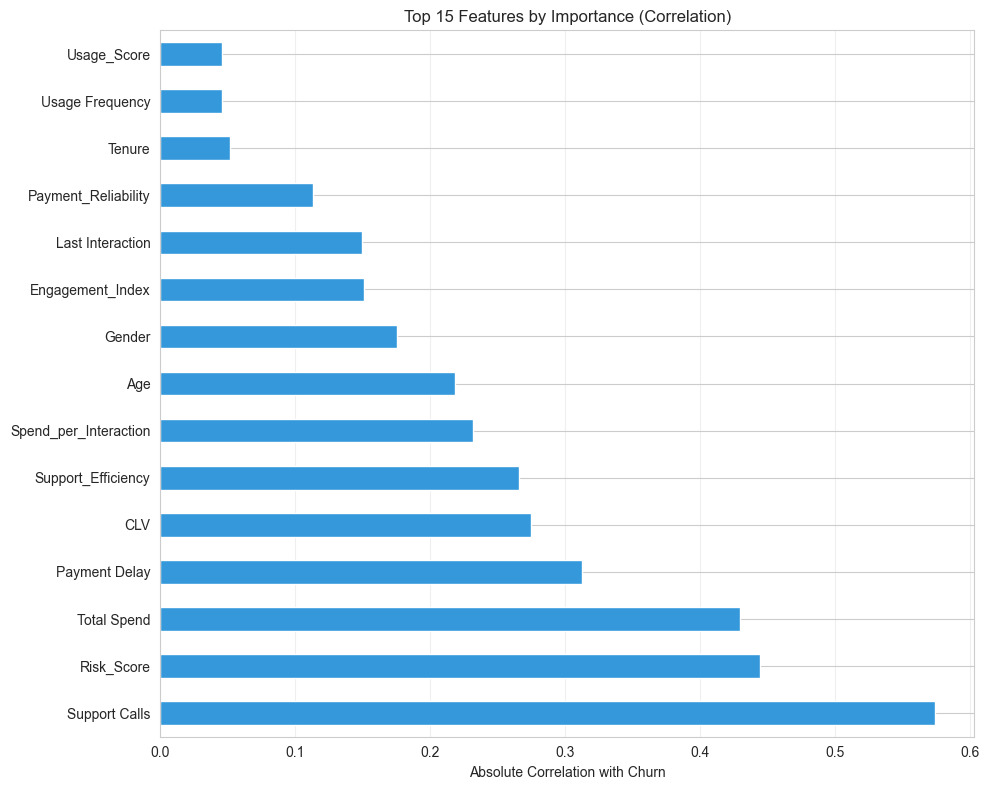

In [37]:
# Calculate correlation for all numerical features

all_numerical = (
    df_encoded
    .select_dtypes(include=[np.number])
    .columns
    .drop(['CustomerID', 'Churn'])
)

feature_importance = (
    df_encoded[all_numerical]
    .corrwith(df_encoded['Churn'])
    .abs()
    .sort_values(ascending=False)
)

print("Top 15 Features by Absolute Correlation with Churn:")
print(feature_importance.head(15))

# Visualize
plt.figure(figsize=(10, 8))
feature_importance.head(15).plot(kind='barh', color='#3498db')
plt.xlabel('Absolute Correlation with Churn')
plt.title('Top 15 Features by Importance (Correlation)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Summary & Export

In [38]:
# Summary Statistics
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset Size: {len(df):,} customers")
print(f"Churn Rate: {(df['Churn'].sum() / len(df) * 100):.2f}%")
print(f"Original Features: {len(df.columns) - 1}")
print(f"Engineered Features: {len(engineered_features)}")
print(f"Total Features (Encoded): {len(df_scaled.columns) - 2}")
print(f"\nNo Missing Values: {df.isnull().sum().sum() == 0}")
print("\nTop 3 Churning Factors (by correlation):")
print(f"  1. {feature_importance.index[0]}: {feature_importance.values[0]:.3f}")
print(f"  2. {feature_importance.index[1]}: {feature_importance.values[1]:.3f}")
print(f"  3. {feature_importance.index[2]}: {feature_importance.values[2]:.3f}")


ANALYSIS SUMMARY

Dataset Size: 440,833 customers
Churn Rate: 56.71%
Original Features: 11
Engineered Features: 7
Total Features (Encoded): 34

No Missing Values: False

Top 3 Churning Factors (by correlation):
  1. Support Calls: 0.574
  2. Risk_Score: 0.444
  3. Total Spend: 0.429


In [ ]:
# Identify numeric and categorical columns
df_work = df_encoded.copy()
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_work.select_dtypes(include=['object','category','bool']).columns.tolist()
print('Numeric cols:', len(num_cols))
print('Categorical cols:', len(cat_cols))

# Impute numerics with median
for c in num_cols:
    if df_work[c].isnull().any():
        med = df_work[c].median()
        df_work[c] = df_work[c].fillna(med)

# Impute categoricals with mode (if available)
for c in cat_cols:
    if df_work[c].isnull().any():
        try:
            mode = df_work[c].mode(dropna=True)[0]
            df_work[c] = df_work[c].fillna(mode)
        except Exception:
            # if mode cannot be determined, fill with string 'missing'
            df_work[c] = df_work[c].fillna('missing')

df_work.isnull().sum()

In [ ]:
# Save processed datasets
root = Path.cwd().parent

df_work.to_csv(root / 'data' / 'processed' / 'customer_churn_processed.csv', index=False)

print("\nProcessed datasets saved:")

print("  - customer_churn_processed.csv")


Processed datasets saved:
  - customer_churn_processed.csv
